# 1. 투표 기반 분류기

<img src='img/p1.jpg' width='700' >

#### 직접 투표 분류기
각 분류기의 예측을 모아서 가장 많이 선택된 클래스로 예측하는 것

확률이 $p$인 이항 분포에서 $n$번 시도 중 $k$번 성공할 확률은

${n \choose k} 0.51^1 (1-0.51)^{(1000-1)} = 1.6 \times 10^{-307}$

이런 식으로 1000번의 과반 직전인 499까지의 확률을 모두 더한 후 1에서 빼면 1000번 던져서 앞면이 과반인 확률이 나온다. 이는 아래의 scipy 라이브러리를 활용하여서도 손 쉽게 계산 가능하다.

즉, 모집단의 시행 수가 증가할 수록 해당 사건이 다수가 될 확률은 증가한다.

In [1]:
from scipy.stats import binom

1-binom.cdf(499, 1000, 0.51)

0.7467502275561786

In [3]:
1-binom.cdf(4999, 10000, 0.51)

0.9777976478701533

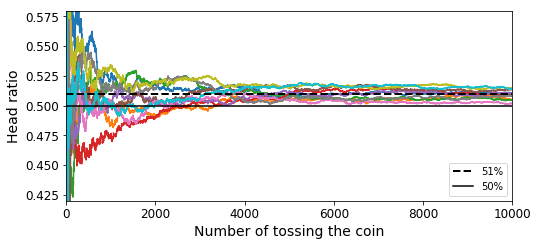

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of tossing the coin")
plt.ylabel("Head ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
# save_fig("law_of_large_numbers_plot")
plt.show()

51%의 정확도를 가진 1000개의 분류 모델들을 앙상블 모델로 구축한다고 가정했을 때,

가장 많이 투표된 클래스로 예측한다고 하면 정확도는 아마 (통계적으로) 75%에 수렴할 것이다.

하지만 이는 모든 분류기들이

#### 완벽하게 독립적이고  오차에 상관관계가 없다는 가정이 전제돼야 한다.

In [8]:
# 데이터 불러오고 샘플링 

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [11]:
# 간접 투표 방식 (soft voting)   모든 분류기들이 predict_proba() 메서드가 있어야 가능.
# 각 분류기들의 샘플 당 예측 확률을 평균을 낸 후 높은 확률 값에 해당하는 클래스로 예측함

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42)                 # SVC는 default로 probability=False라 True로 바꿔주면 됨

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [12]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


soft voting은 확률이 더 높은 쪽에 높은 비중을 두기 때문에 단순히 hard voting보다 대체로 성능이 더 좋음

# 2. 배깅과 페이스팅

훈련셋의 서브셋을 무작위로 구성하여 각 분류기들이 서로 다른 샘플에 대해 학습하게 함.

#### 배깅 (Bagging / Bootstrap Aggregation)
중복을 허용한 샘플링 / 복원추출

#### 페이스팅 (Pasting)
중복을 허용하지 않은 샘플링 / 비복원추출

단일 분류기 VS 앙상블 분류기

편향은 비슷하지만 분산이 줄어듦.

## 2-1. 사이킷런의 배깅과 페이스팅

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,              # 트리 500개
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)            # max_samples 값만큼 전체 샘플에 곱한 양이 샘플링 됨
bag_clf.fit(X_train, y_train)                                               # bootstrap=True : bagging            n_jobs : CPU 코어 수

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [15]:
y_pred = bag_clf.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('Result of BaggingClassifier with 500 trees')
print()
print(confusion_matrix(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

Result of BaggingClassifier with 500 trees

[[57  4]
 [ 8 56]]
accuracy: 0.904
precision: 0.9333333333333333
recall: 0.875


In [24]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print('Result of one DecisionTree')
print()
print(confusion_matrix(y_test, y_pred_tree))
print('accuracy:', accuracy_score(y_test, y_pred_tree))
print('precision:', precision_score(y_test, y_pred_tree))
print('recall:', recall_score(y_test, y_pred_tree))

Result of one DecisionTree

[[57  4]
 [14 50]]
accuracy: 0.856
precision: 0.9259259259259259
recall: 0.78125


In [25]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

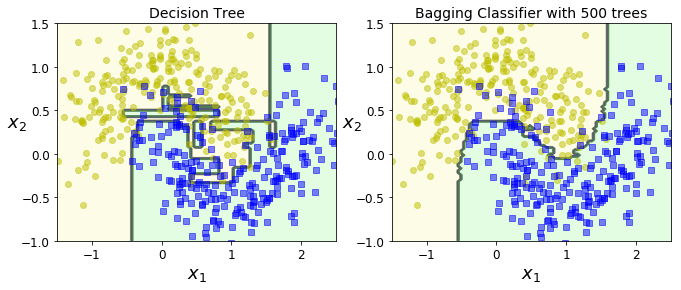

In [26]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Bagging Classifier with 500 trees", fontsize=14)
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Bootstrapping은 subset의 다양성을 증가시키므로 

Bagging이 Pasting보다 편향이 좀 더 높다. 하지만 그만큼 개별 분류기들의 상관관계를 줄이므로 분산을 감소시킨다.

## 2-2. oob 평가

Bootstrap=True로 훈련 세트 크기만큼인 $m$개의 샘플을 선택하는 경우 평균적으로 훈련샘플의 63%정도만 샘플링된다.

$m$이 커지면 $1 - \exp(-1) \approx 63.212%$에 근사한다.

$m$개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $1- {1\over m}$

$m$번 반복했을 때도 선택되지 않을 확률은 $\left( {1-{1\over m}} \right) ^m$

여기에 로그를 취하고 로피탈 정리를 적용하면 $e^{-1}$과 같아진다.

$\therefore 1 - e^{-1} = 0.63212$

#### oob (out-of-bag)
선택되지 않은 훈련 샘플의 나머지

oob 샘플을 통해 cv 대신 앙상블 모델의 성능을 평가할 수 있다. ($\because$훈련에는 사용되지 않은 샘플들이므로)

In [27]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)       # oob_score=True를 통해 oob 평가를 수행함.
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [28]:
y_pred = bag_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

[[59  2]
 [ 9 55]]
accuracy: 0.912
precision: 0.9649122807017544
recall: 0.859375


In [31]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

# 3. 랜덤 패치와 랜덤 서브스페이스

#### 랜덤 패치 (Random Patches method)
훈련 특성과 훈련 샘플을 모두 샘플링 (bootstrap_features=True, max_features<1.0, bootstrap=True, max_samples<1.0)

#### 랜덤 서브스페이스 (Random Subspaces method)
훈련 특성은 샘플링 (bootstrap_features=True, max_features<1.0), 훈련 샘플은 모두 사용 (bootstrap=False, max_samples=1.0)

특성 샘플링은 더 다양한 예측기를 만들며 편향↑ 분산↓

# 4. 랜덤 포레스트

In [32]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
y_pred_rf = rnd_clf.predict(X_test)

print("Result of RandomForest")
print()
print(confusion_matrix(y_test, y_pred_rf))
print('accuracy:', accuracy_score(y_test, y_pred_rf))
print('precision:', precision_score(y_test, y_pred_rf))
print('recall:', recall_score(y_test, y_pred_rf))

Result of RandomForest

[[58  3]
 [ 8 56]]
accuracy: 0.912
precision: 0.9491525423728814
recall: 0.875


RandomForest는 트리의 노드를 분할할 때 전체의 특성 중 최선의 특성을 찾는 것이 아니라

무작위로 선택된 후보 특성들 중에서 최적의 특성을 찾는 식으로 무작위성을 추가한다.

따라서 편향은 증가하지만 분산을 줄이는 효과를 낼 수 있다.

In [36]:
# DecisionTreeClassifier로 RandomForest와 거의 유사한 bagging model을 생성해보자. by splitter='random'

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [37]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('Result of DecisionTree based RandomForest')
print()
print(confusion_matrix(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))

Result of DecisionTree based RandomForest

[[59  2]
 [ 8 56]]
accuracy: 0.92
precision: 0.9655172413793104
recall: 0.875


In [39]:
# 바로 RandomForestClassifier()를 쓰나 DecisionTreeClassifer()로 RF를 만드나 정확도는 거의 비슷하다.

np.sum(y_pred == y_pred_rf) / len(y_pred) 

0.992

## 4-1. 엑스트라 트리

트리의 무작위성을 극단적으로 설정하여 생성한 RF를 익스트림 랜덤 트리 앙상블 (Extremely Radnomized Trees / Extra-Trees)이라고 한다.

각 노드에서 특성의 최적 임계값을 찾는 것은 트리 알고리즘에서 자원이 가장 많이 소요되는 부분이므로 이를 해소하여 연산 속도가 더욱 빨라진다.

## 4-2. 특성 중요도

#### 특성 중요도 (Feature Importance)
어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지에 대한 지표.

- $SR = Sample Ratio = \frac {Node's Sample Number}  {Tree's Sample Number} $
- $IMP = Impurity$
- $CN = Current Node$
- $LN = Left Node$
- $RN = Right Node$

- $ FI = Feature Importance $ 
- $CN_{FI} = {(CN_{SR} \times CN_{IMP}) - (LN_{SR} \times LN_{IMP}) - (RN_{SR} \times RN_{IMP}) \over \sum (CN_{SR} \times CN_{IMP}) - (LN_{SR} \times LN_{IMP}) - (RN_{SR} \times RN_{IMP})}$
- $\sum CN_{FI} =1$

In [56]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

output=[]
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    output.append((name, score))
output.sort()
output

[('petal length (cm)', 0.44103046436395765),
 ('petal width (cm)', 0.4233579963547681),
 ('sepal length (cm)', 0.11249225099876374),
 ('sepal width (cm)', 0.023119288282510326)]

In [57]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

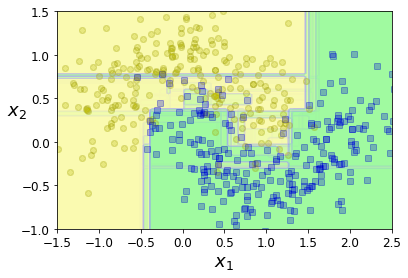

In [58]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [59]:
# MNIST 데이터에 적용

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [61]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [62]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

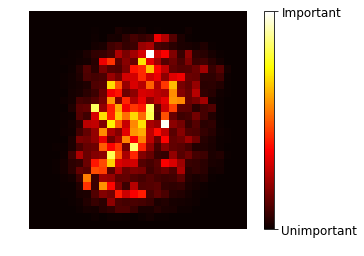

In [63]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Unimportant', 'Important'])
# save_fig("mnist_feature_importance_plot")
plt.show()

# 5. 부스팅

약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법.

앞의 모델을 보완해나가면서 일련의 예측기를 학습하는 방법.

## 5-1. 아다부스트 (AdaBoost / Adaptive Boosting)

<img src='img/p2.jpg' width='500'>

#### AdaBoost
기반이 되는 첫번째 분류기 학습 후 잘못 분류된 샘플의 가중치를 상대적으로 높인 후 다시 학습 (Recursion)

#### AdaBoost by DT

In [64]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

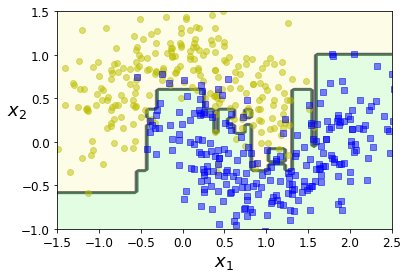

In [65]:
plot_decision_boundary(ada_clf, X, y)

#### AdaBoost by SVM (RBF kernel)

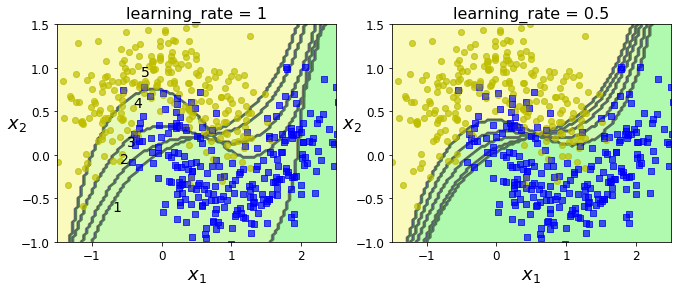

In [66]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)        
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma='auto', random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

# save_fig("boosting_plot")
plt.show()

#### AdaBoost Algorithm

#### 식 7-1.  j번째 예측기의 가중치가 적용된 에러율

$r_j = \dfrac { \underset{ \hat y_j^{(i)} \ne y^{(i)}} {\sum\limits_{i=1} ^m w^{(i)}} }  { \sum\limits_{i=1} ^m w^{(i)} } $

- $initial \quad w^{(i)} = \dfrac {1} {m}$
- $ \hat y_j ^{(i)} $는 $i$번째 샘플에 대한 $j$번째 예측기의 예측

#### 식 7-2. 예측기 가중치
$ \alpha_j = \eta \log { \dfrac {1-r_j} {r_j} } $

- $\eta$ : 학습률 파라미터 (default 1)
- 예측기가 정확할수록 가중치 ↑ ($\because \log$함수는 증가함수)
- 에러율 ($r$)이 0.5보다 높으면 $\dfrac {1-r} {r} <1$이 되어 예측기 가중치는 음수가 됨

#### 식 7-3. 가중치 업데이트 규칙
$ w^{(i)} \leftarrow \begin{cases} 
                        w^{(i)} & \mbox{if} \quad  \hat y_j^{(i)} = y^{(i)} \\
                        w^{(i)} \exp \left( \alpha_j \right) & \mbox{if} \quad  \hat y_j^{(i)} \ne y^{(i)}
                        \end{cases}$

#### 식 7-4. AdaBoost 예측
$ \hat y(\mathbf{x}) = \underset{k} {argmax} \underset{\hat y_j(\mathbf{x})=k} {\sum\limits _{j=1} ^N \alpha_j } $

## 5-2. 그래디언트 부스팅

Iteration마다 이전 예측기가 만든 잔여 오차 (residual error)에 새로운 예측기를 학습시킨다. 

#### 직접 만들어 보는 Gradient Boosting

In [71]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [72]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [73]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [74]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [75]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [76]:
y_pred

array([0.75026781])

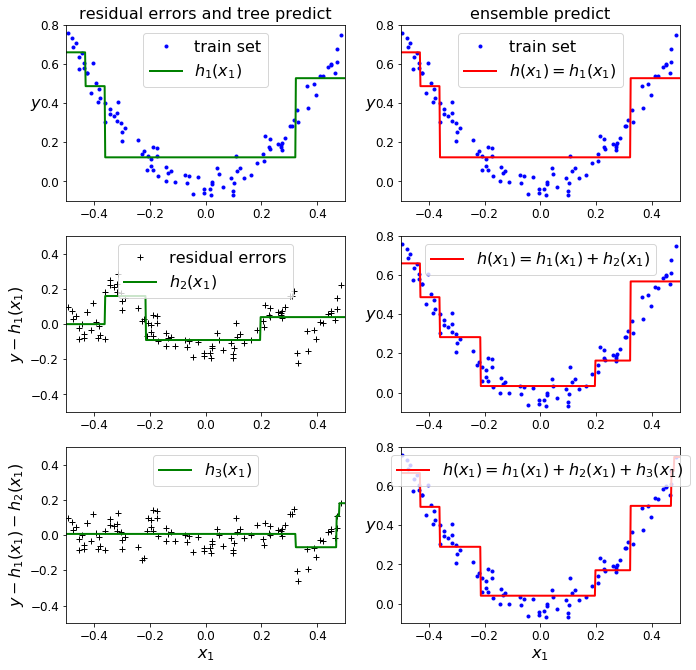

In [77]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="train set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("residual errors and tree predict", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="train set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("ensemble predict", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="residual errors")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

#### GradientBoostingRegressor()

In [79]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [80]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

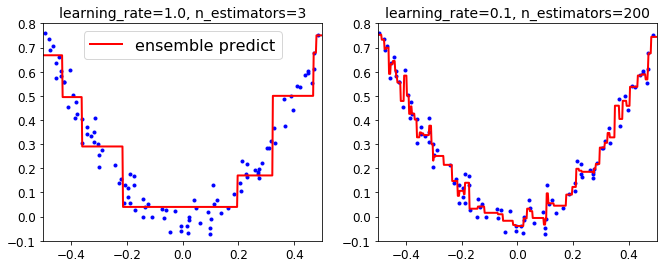

In [81]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="ensemble predict")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

# save_fig("gbrt_learning_rate_plot")
plt.show()

#### 조기 종료를 사용한 GradientBoosting

staged_predict() 메서드는 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator)를 반환한다.

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors=[mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [92]:
min_error = np.min(errors)

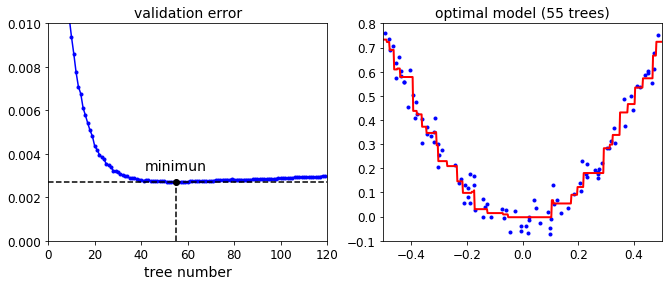

In [93]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "minimun", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("tree number")
plt.title("validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("optimal model (%d trees)" % bst_n_estimators, fontsize=14)

# save_fig("early_stopping_gbrt_plot")
plt.show()

#### 연속 5번 동안 검증 오차가 줄어들지 않으면 강제 종료

In [94]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [95]:
print('n_estimators: ',gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

n_estimators:  61
최소 검증 MSE: 0.002712853325235463


# 6. 스태킹

<img src='img/p3.jpg' width='600'>
<img src='img/p4.jpg' width='600'>
<img src='img/p5.jpg' width='600'>
<img src='img/p6.jpg' width='600'>